In [1]:
import os 
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
import numpy as np
import nltk
import re
from wordcloud import WordCloud

This dataset contains artist data for ~20k artists whose songs made it to the Spotify weekly charts and ~136k additional artists who had at least one feature with at least one of the chart artists.

Further, information on the occurrence of features between all of these artists is included, allowing to generate a network with 135k+ musicians as nodes and 300k+ collaboration edges between them

spotify_id: A unique identifier for an artist or entity on Spotify.
name: The name of the artist or entity.
followers: The number of followers the artist has on Spotify.
popularity: A numeric value representing the artist's popularity on Spotify, likely based on metrics such as streams, saves, and other user interactions(it'S in percentile)
genres: A list of genres associated with the artist, enclosed in square brackets (we have 2585 genres in total)
chart_hits: A list of countries and chart positions the artist has achieved, formatted as ['country_code (rank)'].


In [2]:
nodes = pd.read_csv('/home/manoj/tuhh/data_science_3rd_sem/deep_learning_for_social_analytics/project/deep-learning-for-social-analytics-project/artist_and_music_data/nodes.csv')
edges = pd.read_csv('/home/manoj/tuhh/data_science_3rd_sem/deep_learning_for_social_analytics/project/deep-learning-for-social-analytics-project/artist_and_music_data/edges.csv')

In [3]:
nodes.shape

(156422, 6)

In [4]:
nodes.dtypes


spotify_id     object
name           object
followers     float64
popularity      int64
genres         object
chart_hits     object
dtype: object

In [5]:
nodes.isnull().sum()
# We have around  136781 entries null in chart_hits.
# We have lot of genres [] empty strings which we will be looked later.

spotify_id         0
name               4
followers          4
popularity         0
genres             0
chart_hits    136781
dtype: int64

In [6]:
print(nodes[nodes['name'].isnull()])


                    spotify_id name  followers  popularity genres  chart_hits
12785   4oPYazJJ1o4rWBrTw9lm40  NaN    12853.0          42     []  ['no (1)']
118831  0TssKMrMlrXSxIwNrghB1V  NaN       14.0          25     []         NaN
122392  6JWuxVtbFw3VM4dxG8WIyg  NaN      632.0          38     []         NaN
147330  4EE7hLCmir49XJjVXPk07e  NaN    10840.0          17     []         NaN


In [7]:
nodes.dropna(subset=['name'], inplace=True)


In [8]:
print(nodes[nodes['followers'].isnull()])


                    spotify_id              name  followers  popularity  \
26079   4Jgl9FmNQF6ontIRyY19Ig             MC JL        NaN          18   
105067  3cCFieWefBXyyDRsjNuArE  Christian Wagner        NaN           4   
127808  1lLHQcDQFM03FcxZ5mQimA     Pekin Ibrahim        NaN           9   
136354  7estJE1m5cJnQs3Rc4iar0           Toni102        NaN           2   

                          genres chart_hits  
26079   ['deep funk ostentacao']        NaN  
105067                        []        NaN  
127808                        []        NaN  
136354                        []        NaN  


In [9]:
nodes.dropna(subset=['followers'], inplace=True)


In [10]:
nodes.isnull().sum()

spotify_id         0
name               0
followers          0
popularity         0
genres             0
chart_hits    136774
dtype: int64

In [11]:

from concurrent.futures import ProcessPoolExecutor
from langdetect import detect, DetectorFactory

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Fast ASCII check to quickly determine if a text is likely English
        if all(ord(char) < 128 for char in text):
            return True
        return detect(text) == 'en'
    except:
        return False

def filter_english_on_name(df):
    with ProcessPoolExecutor() as executor:
        # Map the language detection function to the 'name' column
        name_english = list(executor.map(is_english, df['name']))
    
    # Return the filtered DataFrame where 'name' is detected as English
    return df[name_english]

nodes_english = filter_english_on_name(nodes)

# Print or further process the filtered DataFrame
print(nodes_english)

                    spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0             

In [12]:
# For 136774 records we don't know weather the song was hit in a country and it's rank in the country.
nodes_english[nodes_english['chart_hits'].isnull()]

,spotify_id,name,followers,popularity,genres,chart_hits
124,55tJwpPIz9BMrSLM45iEXX,9MUSES,58.0,38,"['k-pop', 'k-pop girl group']",NaN
349,0fM4WhKpjJZc3a0eX947Tc,Sirius,1.0,25,[],NaN
769,6RDpAm5XMUZqVZlBJ1UYQw,Starian,2.0,45,[],NaN
892,0fAxJ75WJT3STJb3xWtpbc,MOLY,25.0,43,"['dominican pop', 'modern salsa', 'pop peruano...",NaN
3700,0xHANYVyAfbp6GmjPKcOad,Harris Baba,1.0,21,[],NaN
...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,['classic swedish pop'],NaN
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,[],NaN
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,[],NaN
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,[],NaN


In [13]:
nodes_english[['name', 'followers', 'popularity', 'genres']].to_csv('english_artist_with_followers.csv', index=False)

# Not required this one

# Filter rows where 'chart_hits' is NaN
chart_hits_nan_rows = nodes[nodes['chart_hits'].isnull()]

# Save the filtered DataFrame to a new CSV file
chart_hits_nan_rows.to_csv('song_hit_exp_in_country.csv', index=False)


df_null_country = pd.read_csv('song_hit_exp_in_country.csv')
df_null_country.shape
# Export all the records where the chart_hits are null to a new csv song_hit_exp_in_country.csv

In [14]:
nodes_english.columns

Index(['spotify_id', 'name', 'followers', 'popularity', 'genres',
       'chart_hits'],
      dtype='object')

In [15]:
# Remove the 'spotify_id' column
nodes_english = nodes_english.drop(columns=['spotify_id'])

# Extract rows where 'chart_hits' is not null
df = nodes_english[nodes_english['chart_hits'].notnull()]


In [16]:
df.shape

(17780, 5)

In [17]:
df.to_csv('artist_with_country_rank.csv', index=False)

In [18]:
df_country = pd.read_csv('artist_with_country_rank.csv')

In [51]:
import pandas as pd
import ast

# Dictionary mapping ISO 3166-1 alpha-2 country codes to country names
country_code_to_name = {
    'AF': 'Afghanistan', 'AL': 'Albania', 'DZ': 'Algeria', 'AD': 'Andorra', 'AO': 'Angola',
    'AG': 'Antigua and Barbuda', 'AR': 'Argentina', 'AM': 'Armenia', 'AU': 'Australia',
    'AT': 'Austria', 'AZ': 'Azerbaijan', 'BS': 'Bahamas', 'BH': 'Bahrain', 'BD': 'Bangladesh',
    'BB': 'Barbados', 'BY': 'Belarus', 'BE': 'Belgium', 'BZ': 'Belize', 'BJ': 'Benin',
    'BT': 'Bhutan', 'BO': 'Bolivia', 'BA': 'Bosnia and Herzegovina', 'BW': 'Botswana',
    'BR': 'Brazil', 'BN': 'Brunei', 'BG': 'Bulgaria', 'BF': 'Burkina Faso', 'BI': 'Burundi',
    'CV': 'Cabo Verde', 'KH': 'Cambodia', 'CM': 'Cameroon', 'CA': 'Canada',
    'CF': 'Central African Republic', 'TD': 'Chad', 'CL': 'Chile', 'CN': 'China',
    'CO': 'Colombia', 'KM': 'Comoros', 'CG': 'Congo (Congo-Brazzaville)',
    'CR': 'Costa Rica', 'HR': 'Croatia', 'CU': 'Cuba', 'CY': 'Cyprus',
    'CZ': 'Czechia (Czech Republic)', 'CD': 'Democratic Republic of the Congo',
    'DK': 'Denmark', 'DJ': 'Djibouti', 'DM': 'Dominica', 'DO': 'Dominican Republic',
    'EC': 'Ecuador', 'EG': 'Egypt', 'SV': 'El Salvador', 'GQ': 'Equatorial Guinea',
    'ER': 'Eritrea', 'EE': 'Estonia', 'SZ': 'Eswatini', 'ET': 'Ethiopia',
    'FJ': 'Fiji', 'FI': 'Finland', 'FR': 'France', 'GA': 'Gabon', 'GM': 'Gambia',
    'GE': 'Georgia', 'DE': 'Germany', 'GH': 'Ghana', 'GR': 'Greece', 'GD': 'Grenada',
    'GT': 'Guatemala', 'GN': 'Guinea', 'GW': 'Guinea-Bissau', 'GY': 'Guyana',
    'HT': 'Haiti', 'VA': 'Holy See', 'HN': 'Honduras', 'HU': 'Hungary', 'IS': 'Iceland', 'HK': 'Hong kong',
    'IN': 'India', 'ID': 'Indonesia', 'IR': 'Iran', 'IQ': 'Iraq', 'IE': 'Ireland',
    'IL': 'Israel', 'IT': 'Italy', 'JM': 'Jamaica', 'JP': 'Japan', 'JO': 'Jordan',
    'KZ': 'Kazakhstan', 'KE': 'Kenya', 'KI': 'Kiribati', 'KW': 'Kuwait', 'KG': 'Kyrgyzstan',
    'LA': 'Laos', 'LV': 'Latvia', 'LB': 'Lebanon', 'LS': 'Lesotho', 'LR': 'Liberia',
    'LY': 'Libya', 'LI': 'Liechtenstein', 'LT': 'Lithuania', 'LU': 'Luxembourg',
    'MG': 'Madagascar', 'MW': 'Malawi', 'MY': 'Malaysia', 'MV': 'Maldives', 'ML': 'Mali',
    'MT': 'Malta', 'MH': 'Marshall Islands', 'MR': 'Mauritania', 'MU': 'Mauritius',
    'MX': 'Mexico', 'FM': 'Micronesia', 'MD': 'Moldova', 'MC': 'Monaco', 'MN': 'Mongolia',
    'ME': 'Montenegro', 'MA': 'Morocco', 'MZ': 'Mozambique', 'MM': 'Myanmar (formerly Burma)',
    'NA': 'Namibia', 'NR': 'Nauru', 'NP': 'Nepal', 'NL': 'Netherlands', 'NZ': 'New Zealand',
    'NI': 'Nicaragua', 'NE': 'Niger', 'NG': 'Nigeria', 'KP': 'North Korea',
    'MK': 'North Macedonia', 'NO': 'Norway', 'OM': 'Oman', 'PK': 'Pakistan', 'PW': 'Palau',
    'PS': 'Palestine State', 'PA': 'Panama', 'PG': 'Papua New Guinea', 'PY': 'Paraguay',
    'PE': 'Peru', 'PH': 'Philippines', 'PL': 'Poland', 'PT': 'Portugal', 'QA': 'Qatar',
    'RO': 'Romania', 'RU': 'Russia', 'RW': 'Rwanda', 'KN': 'Saint Kitts and Nevis',
    'LC': 'Saint Lucia', 'VC': 'Saint Vincent and the Grenadines', 'WS': 'Samoa',
    'SM': 'San Marino', 'ST': 'Sao Tome and Principe', 'SA': 'Saudi Arabia', 'SN': 'Senegal',
    'RS': 'Serbia', 'SC': 'Seychelles', 'SL': 'Sierra Leone', 'SG': 'Singapore',
    'SK': 'Slovakia', 'SI': 'Slovenia', 'SB': 'Solomon Islands', 'SO': 'Somalia',
    'ZA': 'South Africa', 'KR': 'South Korea', 'SS': 'South Sudan', 'ES': 'Spain',
    'LK': 'Sri Lanka', 'SD': 'Sudan', 'SR': 'Suriname', 'SE': 'Sweden', 'CH': 'Switzerland',
    'SY': 'Syria', 'TJ': 'Tajikistan', 'TZ': 'Tanzania', 'TH': 'Thailand',
    'TL': 'Timor-Leste', 'TG': 'Togo', 'TO': 'Tonga', 'TT': 'Trinidad and Tobago', 'TW':'Taiwan',
    'TN': 'Tunisia', 'TR': 'Turkey', 'TM': 'Turkmenistan', 'TV': 'Tuvalu', 'UG': 'Uganda',
    'UA': 'Ukraine', 'AE': 'United Arab Emirates', 'GB': 'United Kingdom',
    'US': 'United States of America', 'UY': 'Uruguay', 'UZ': 'Uzbekistan', 'VU': 'Vanuatu',
    'VE': 'Venezuela', 'VN': 'Vietnam', 'YE': 'Yemen', 'ZM': 'Zambia', 'ZW': 'Zimbabwe'
}

# Dictionary mapping ISO 3166-1 alpha-2 country codes to country names
country_code_to_name = {
    'AF': 'Afghanistan', 'AL': 'Albania', 'DZ': 'Algeria', 'AD': 'Andorra', 'AO': 'Angola',
    # ... (truncated for brevity)
    'ZW': 'Zimbabwe'
}

# Convert keys to lowercase for easier matching
country_code_to_name = {k.lower(): v for k, v in country_code_to_name.items()}

# Function to parse the 'chart_hits' column
def parse_chart_hits(chart_hits):
    if pd.isna(chart_hits):
        return []
    # Safely evaluate the string to a list
    entries = ast.literal_eval(chart_hits)
    # Extract country and rank as tuples
    parsed = [(entry.split(' ')[0].lower(), int(entry.split('(')[1][:-1])) for entry in entries]
    return parsed

# Assuming df_country is your initial DataFrame
df_country['parsed_chart_hits'] = df_country['chart_hits'].apply(parse_chart_hits)

# Initialize a DataFrame to hold the new columns
rank_data = pd.DataFrame(index=df_country.index)

# Fill these columns with the ranks from 'chart_hits' efficiently
for code, full_name in country_code_to_name.items():
    full_name_column = full_name.replace(' ', '_')
    # Calculate rank column
    rank_data[full_name_column] = [
        next((rank for entry_code, rank in parsed if entry_code == code), 0) 
        for parsed in df_country['parsed_chart_hits']
    ]

# Concatenate original DataFrame with new rank data
df_country = pd.concat([df_country.drop(columns=['parsed_chart_hits']), rank_data], axis=1)

# Save the final result
df_country.to_csv('ordinal_country_rank.csv', index=False)

# Print the first few rows of the resulting DataFrame
print(df_country.head())

/tmp/ipykernel_11730/673191125.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_country['parsed_chart_hits'] = df_country['chart_hits'].apply(parse_chart_hits)


                 name  followers  popularity  \
0           Byklubben     1738.0          24   
1            Kontra K  1999676.0          72   
2               Maxim    34596.0          36   
3  Christopher Martin   249233.0          52   
4       Jakob Hellman    21193.0          39   

                                              genres  \
0                     ['nordic house', 'russelater']   
1             ['christlicher rap', 'german hip hop']   
2                                                 []   
3  ['dancehall', 'lovers rock', 'modern reggae', ...   
4  ['classic swedish pop', 'norrbotten indie', 's...   

                                          chart_hits  Afghanistan  Albania  \
0                                         ['no (3)']            0        0   
1  ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...            0        0   
2                                         ['de (1)']            0        0   
3                               ['at (1)', 'de (1)']          

In [20]:
df_country.shape

(17780, 201)

In [21]:
import pandas as pd

# Load the DataFrame from the CSV file
df_1 = pd.read_csv('ordinal_country_rank.csv')

# Filter columns where the column name has more than 2 characters
df = df_1[[col for col in df_1.columns if len(col) > 2]]

# Print the first few rows of the resulting DataFrame
print(df.head())

                 name  followers  popularity  \
0           Byklubben     1738.0          24   
1            Kontra K  1999676.0          72   
2               Maxim    34596.0          36   
3  Christopher Martin   249233.0          52   
4       Jakob Hellman    21193.0          39   

                                              genres  \
0                     ['nordic house', 'russelater']   
1             ['christlicher rap', 'german hip hop']   
2                                                 []   
3  ['dancehall', 'lovers rock', 'modern reggae', ...   
4  ['classic swedish pop', 'norrbotten indie', 's...   

                                          chart_hits  Afghanistan  Albania  \
0                                         ['no (3)']            0        0   
1  ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...            0        0   
2                                         ['de (1)']            0        0   
3                               ['at (1)', 'de (1)']          

In [22]:
lowest_value = df['popularity'].min()
highest_value = df['popularity'].max()

print(f'Lowest value: {lowest_value}')
print(f'Highest value: {highest_value}')

Lowest value: 0
Highest value: 100


In [23]:
df.shape

(17780, 201)

In [24]:
df.isnull().sum()

name          0
followers     0
popularity    0
genres        0
chart_hits    0
             ..
Venezuela     0
Vietnam       0
Yemen         0
Zambia        0
Zimbabwe      0
Length: 201, dtype: int64

# Since I changed the logic and did ordinal data for rank this is not required.
# Knowledge purpose 
lowest_value = df['rank'].min()
highest_value = df['rank'].max()

print(f'Lowest value: {lowest_value}') # was from  1
print(f'Highest value: {highest_value}') # till 379 

In [25]:
print(df[df['name'].isnull()])
# We will remove the row which doesn't have the artist name and any way it's 1 record.

Empty DataFrame
Columns: [name, followers, popularity, genres, chart_hits, Afghanistan, Albania, Algeria, Andorra, Angola, Antigua_and_Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bhutan, Bolivia, Bosnia_and_Herzegovina, Botswana, Brazil, Brunei, Bulgaria, Burkina_Faso, Burundi, Cabo_Verde, Cambodia, Cameroon, Canada, Central_African_Republic, Chad, Chile, China, Colombia, Comoros, Congo_(Congo-Brazzaville), Costa_Rica, Croatia, Cuba, Cyprus, Czechia_(Czech_Republic), Democratic_Republic_of_the_Congo, Denmark, Djibouti, Dominica, Dominican_Republic, Ecuador, Egypt, El_Salvador, Equatorial_Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Fiji, Finland, France, Gabon, Gambia, Georgia, Germany, Ghana, Greece, Grenada, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Holy_See, Honduras, Hungary, Iceland, Hong_kong, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Jamaica, Japan, Jordan, Kazakhstan, K

In [26]:
df.head(10)

,name,followers,popularity,genres,chart_hits,Afghanistan,Albania,Algeria,Andorra,Angola,...,United_Kingdom,United_States_of_America,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Maxim,34596.0,36,[],['de (1)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Madh,26677.0,19,[],['it (2)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Juice,11312.0,37,"['swedish drill', 'swedish hip hop', 'swedish ...",['se (4)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Nehuda,36252.0,31,['francoton'],['fr (1)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,VovaZiLvova,14619.0,43,"['ukrainian hip hop', 'ukrainian pop', 'ukrain...",['ua (1)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Nata Record,188.0,12,[],['do (1)'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# lets drop the columns which are not required.
df.drop(columns=['chart_hits'], inplace=True)
df.head(10)

,name,followers,popularity,genres,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua_and_Barbuda,...,United_Kingdom,United_States_of_America,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,Byklubben,1738.0,24,"['nordic house', 'russelater']",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Maxim,34596.0,36,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Madh,26677.0,19,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Juice,11312.0,37,"['swedish drill', 'swedish hip hop', 'swedish ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Nehuda,36252.0,31,['francoton'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,VovaZiLvova,14619.0,43,"['ukrainian hip hop', 'ukrainian pop', 'ukrain...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Nata Record,188.0,12,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df['genres']

0                           ['nordic house', 'russelater']
1                   ['christlicher rap', 'german hip hop']
2                                                       []
3        ['dancehall', 'lovers rock', 'modern reggae', ...
4        ['classic swedish pop', 'norrbotten indie', 's...
                               ...                        
17775                  ['turkish hip hop', 'turkish trap']
17776      ['finnish dance pop', 'finnish pop', 'iskelma']
17777                                       ['german pop']
17778                                   ['urbano espanol']
17779    ['chilean rock', 'rap chileno', 'reggae en esp...
Name: genres, Length: 17780, dtype: object

In [29]:

# Convert genre strings to lists
df['genre_list'] = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Collect all unique genres
unique_genres = set(genre for sublist in df['genre_list'] for genre in sublist)

# Print the unique genres
print("Unique genres:")
for genre in unique_genres:
    print(genre)

Unique genres:
digital hardcore
bass trap
gypsy punk
mexican rock
kiwi rock
baltimore hip hop
nz reggae
hip hop boliviano
brazilian emo
dalarna indie
sholawat
balkan hip hop
houston rap
classic colombian pop
minnesota hip hop
turkish reggae
swedish trap
japanese heavy metal
russian pop punk
pop argentino
indonesian folk pop
australian children's music
kollywood
chiptune
new england americana
polish viral rap
lagu sabahan
dance-punk
pittsburgh indie
norwegian gospel
berlin minimal techno
indietronica
gotlandsk musik
brazilian stoner rock
pakistani pop
visor
australian rock
trap chileno
avant-garde jazz
native american hip hop
moldovan pop
malaysian tamil pop
rock andaluz
junior eurovision
singaporean indie
ukrainian classical
funk capixaba
boston rock
chinese indie
israeli hip hop
japanese indie rock
nova musica carioca
kazakh pop
uk contemporary jazz
talent show
nueva cancion
norwegian rock
irish indie
indonesian folk
musica gaucha
lund indie
spectra
axe
macedonian hip hop
experimental

In [30]:
import pandas as pd
import ast
import re


# Convert genre strings to lists
df['genre_list'] = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Collect all unique genres
unique_genres = set(genre for sublist in df['genre_list'] for genre in sublist)

# Define the mapping from sub-genres to prominent genres
top_genres = {
    'Pop': ['pop', 'j-pop', 'k-pop', 'synthpop', 'electropop', 'teen pop'],
    'Rock': ['rock', 'punk', 'garage'],
    'Hip Hop': ['hip hop', 'rap', 'drill'],
    'Electronic': ['edm', 'house', 'techno', 'electronic', 'trance', 'dance'],
    'Jazz': ['jazz'],
    'Folk World': ['folk', 'celtic', 'world', 'americana', 'country'],
    'RandB Soul': ['soul', 'r&b', 'rhythm and blues', 'funk', 'blues'],
    'Metal': ['metal'],
    'Classical Orchestral': ['classical', 'orchestral', 'symphony'],
    'Reggae Dancehall': ['reggae', 'dub', 'riddim', 'ska'],
    'Latin': ['salsa', 'latin', 'bachata', 'cumbia'],
    'Alternative Indie': ['indie', 'alternative', 'emo'],
    'Blues': ['blues'],
    'Punk': ['punk'],
    'Soundtrack': ['soundtrack', 'anime', 'broadway', 'movie']
}

# Function to assign each unique genre to a top genre
def assign_genre(unique_genre):
    # Clean up the genre string for matching
    genre_clean = unique_genre.lower().strip()
    
    # Check against each top genre's sub-genres
    for top_genre, subgenres in top_genres.items():
        for subgenre in subgenres:
            # Use regex to check for word boundaries to avoid partial matches
            if re.search(rf'\b{subgenre}\b', genre_clean):
                return top_genre
    return 'unknown'

# Map each unique genre to a top genre
genre_mapping = {genre: assign_genre(genre) for genre in unique_genres}

# Apply this mapping to a column in your DataFrame
df['prominent_genres'] = df['genre_list'].apply(
    lambda genres: [genre_mapping.get(genre, 'Other') for genre in genres]
)

# You can now view the resultant DataFrame to check the mappings
print(df[['genres', 'prominent_genres']])

                                                  genres  \
0                         ['nordic house', 'russelater']   
1                 ['christlicher rap', 'german hip hop']   
2                                                     []   
3      ['dancehall', 'lovers rock', 'modern reggae', ...   
4      ['classic swedish pop', 'norrbotten indie', 's...   
...                                                  ...   
17775                ['turkish hip hop', 'turkish trap']   
17776    ['finnish dance pop', 'finnish pop', 'iskelma']   
17777                                     ['german pop']   
17778                                 ['urbano espanol']   
17779  ['chilean rock', 'rap chileno', 'reggae en esp...   

                                        prominent_genres  
0                                  [Electronic, unknown]  
1                                     [Hip Hop, Hip Hop]  
2                                                     []  
3      [unknown, Rock, Reggae Dancehall, Re

In [31]:
df.shape

(17780, 202)

In [32]:

unique_prominent_genres = set(gen for sublist in df['prominent_genres'] for gen in sublist)

# Count the number of unique prominent genres
unique_count = len(unique_prominent_genres)

# Print the count and the unique prominent genres
print(f"Number of unique prominent genres: {unique_count}")
print("Unique prominent genres:", unique_prominent_genres)

Number of unique prominent genres: 14
Unique prominent genres: {'Pop', 'Classical Orchestral', 'unknown', 'Metal', 'Alternative Indie', 'Jazz', 'Folk World', 'Rock', 'Reggae Dancehall', 'Soundtrack', 'Electronic', 'Latin', 'RandB Soul', 'Hip Hop'}


In [33]:
df.head(10)

,name,followers,popularity,genres,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua_and_Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe,genre_list,prominent_genres
0,Byklubben,1738.0,24,"['nordic house', 'russelater']",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[nordic house, russelater]","[Electronic, unknown]"
1,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']",0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"[christlicher rap, german hip hop]","[Hip Hop, Hip Hop]"
2,Maxim,34596.0,36,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[],[]
3,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[dancehall, lovers rock, modern reggae, reggae...","[unknown, Rock, Reggae Dancehall, Reggae Dance..."
4,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[classic swedish pop, norrbotten indie, swedis...","[Pop, Alternative Indie, Pop]"
5,Madh,26677.0,19,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[],[]
6,Juice,11312.0,37,"['swedish drill', 'swedish hip hop', 'swedish ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[swedish drill, swedish hip hop, swedish trap,...","[Hip Hop, Hip Hop, unknown, Pop]"
7,Nehuda,36252.0,31,['francoton'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[francoton],[unknown]
8,VovaZiLvova,14619.0,43,"['ukrainian hip hop', 'ukrainian pop', 'ukrain...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[ukrainian hip hop, ukrainian pop, ukrainian r...","[Hip Hop, Pop, Rock]"
9,Nata Record,188.0,12,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[],[]


In [34]:
# Step 1: Explode the genre lists into separate rows
df_exploded = df.explode('prominent_genres')

# Step 2: Ensure deduplication across these exploded items per original entry
df_exploded = df_exploded.groupby(df_exploded.index).apply(lambda x: x.drop_duplicates(subset=['prominent_genres'])).reset_index(level=0, drop=True)

# Step 3: Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df_exploded['prominent_genres'])

# Step 4: Sum up genre indicators for each original record by grouping back using the initial index
final_one_hot_encoded = one_hot_encoded.groupby(one_hot_encoded.index).sum()

# Combine back to original DataFrame as needed
df_final = pd.concat([df.drop(columns=['prominent_genres']), final_one_hot_encoded], axis=1)

# Display the one-hot encoded result
print(df_final)

                      name  followers  popularity  \
0                Byklubben     1738.0          24   
1                 Kontra K  1999676.0          72   
2                    Maxim    34596.0          36   
3       Christopher Martin   249233.0          52   
4            Jakob Hellman    21193.0          39   
...                    ...        ...         ...   
17775               Allame   382819.0          53   
17776         Erika Vikman    12630.0          47   
17777                 Rubi     7598.0          44   
17778             Kabasaki     5657.0          57   
17779  Movimiento Original       17.0          62   

                                                  genres  Afghanistan  \
0                         ['nordic house', 'russelater']            0   
1                 ['christlicher rap', 'german hip hop']            0   
2                                                     []            0   
3      ['dancehall', 'lovers rock', 'modern reggae', ...            0  

In [35]:
df_final = df_final.drop(columns=['genres'])


In [36]:
df_final.to_csv('cleaned_v1.csv', index=False)


In [37]:
df_final.isnull().sum()

name                0
followers           0
popularity          0
Afghanistan         0
Albania             0
                   ..
RandB Soul          0
Reggae Dancehall    0
Rock                0
Soundtrack          0
unknown             0
Length: 214, dtype: int64

In [38]:
df_final.shape

(17780, 214)

In [39]:
df.to_csv('17k_artist_with_country_wise_and_global_rank.csv')

In [40]:
df = pd.read_csv('cleaned_v1.csv')

In [41]:
#Check the top artist in spotify

unique_artists = df.sort_values('popularity', ascending=False).drop_duplicates(subset=['name'])

# Now select the top 10 unique artists by popularity
top_unique_artists = unique_artists.nlargest(10, 'popularity')[['name', 'popularity']]
print(top_unique_artists)

                name  popularity
10094      Bad Bunny         100
16922          Drake          95
4180    Taylor Swift          94
12504     The Weeknd          93
14536   Harry Styles          91
17640     Kanye West          91
15843            BTS          91
4944          Eminem          90
12794     Ed Sheeran          90
5620   Justin Bieber          90


/tmp/ipykernel_11730/122844485.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='popularity', data=top_unique_artists, palette='viridis')


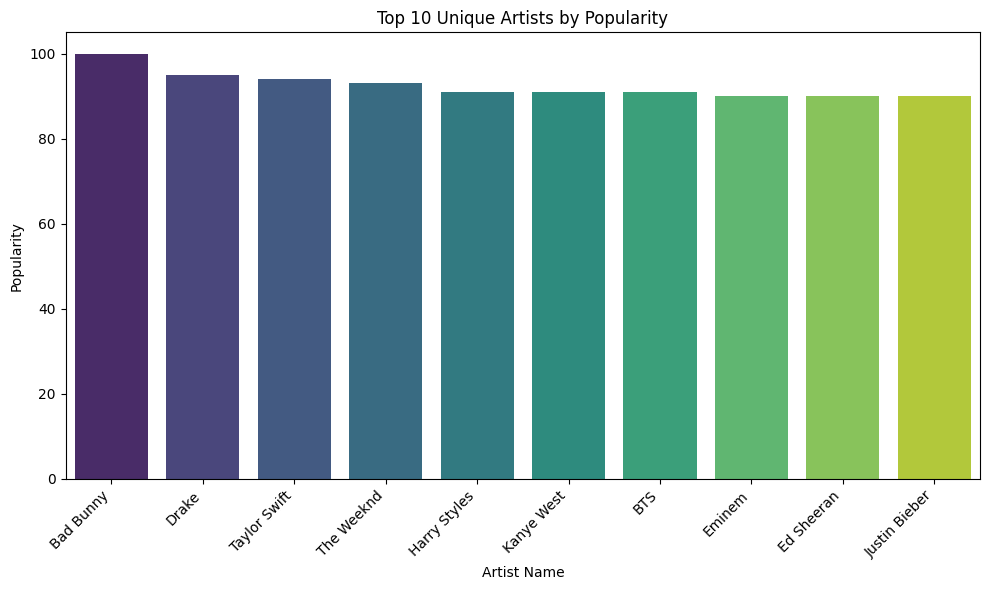

In [42]:
import seaborn as sns

# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='popularity', data=top_unique_artists, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Unique Artists by Popularity')
plt.xlabel('Artist Name')
plt.ylabel('Popularity')
plt.tight_layout()

plt.show()

In [43]:
df.head(10)

,name,followers,popularity,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua_and_Barbuda,Argentina,...,Hip Hop,Jazz,Latin,Metal,Pop,RandB Soul,Reggae Dancehall,Rock,Soundtrack,unknown
0,Byklubben,1738.0,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Kontra K,1999676.0,72,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Maxim,34596.0,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Christopher Martin,249233.0,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
4,Jakob Hellman,21193.0,39,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,Madh,26677.0,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Juice,11312.0,37,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
7,Nehuda,36252.0,31,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,VovaZiLvova,14619.0,43,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
9,Nata Record,188.0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:

# Columns from which to extract the rank
rank_columns = df.columns[3:215]

# Convert all rank columns to numeric, coercing errors to NaN
df[rank_columns] = df[rank_columns].apply(pd.to_numeric, errors='coerce')

# Create a dictionary to store top artists per country
top_artists_in_countries = {}

# Iterate over each country column to find the top artists
for country in rank_columns:
    # Sort the DataFrame by the country's rank, to find the top artists in that country
    sorted_df = df.sort_values(by=country, ascending=True)
    
    # Select only those with a valid rank (greater than 0 and less or equal to 300)
    valid_artists = sorted_df[(sorted_df[country] > 0) & (sorted_df[country] <= 300)]
    
    # Store the top artists for this country only 5 is fine for now
    top_artists_in_countries[country] = valid_artists.head(5)

# To get the top 10 countries with most top-ranked artists
country_rank_tally = {country: df[country][(df[country] > 0) & (df[country] <= 300)].count() for country in rank_columns}
top_5_countries = sorted(country_rank_tally, key=country_rank_tally.get, reverse=True)[:5]

# Gather the top artists from these top countries
top_artists_final = {}
for country in top_5_countries:
    top_artists_final[country] = top_artists_in_countries[country]

# Now `top_artists_final` contains the top 10 artists for each of the top 10 countries
for country, artists in top_artists_final.items():
    print(f"Country: {country}")
    print(artists[['name', 'followers', 'popularity', country]])
    print("\n")

Country: Pop
               name  followers  popularity  Pop
17765       Normani  2102005.0          70    1
17767         LeeHi  1381370.0          66    1
17771  Norlie & KKV   404641.0          54    1
17761     Olly Murs  3239700.0          65    1
17762       Saliboy    54784.0          47    1


Country: unknown
               name  followers  popularity  unknown
17610     ALOHOMORA       68.0          21        1
15529         Tedua  1350219.0          67        1
15784    Deep Sleep    47423.0          49        1
13382    Urban Love     8238.0          54        1
13612  Denny Caknan    17423.0           0        1


Country: Hip Hop
                    name  followers  popularity  Hip Hop
17500             KIKESA   263590.0          54        1
15500  Baco Exu do Blues  1166084.0          69        1
17513             Truwer   174404.0          50        1
8            VovaZiLvova    14619.0          43        1
7773                Raus     2365.0          25        1


Count

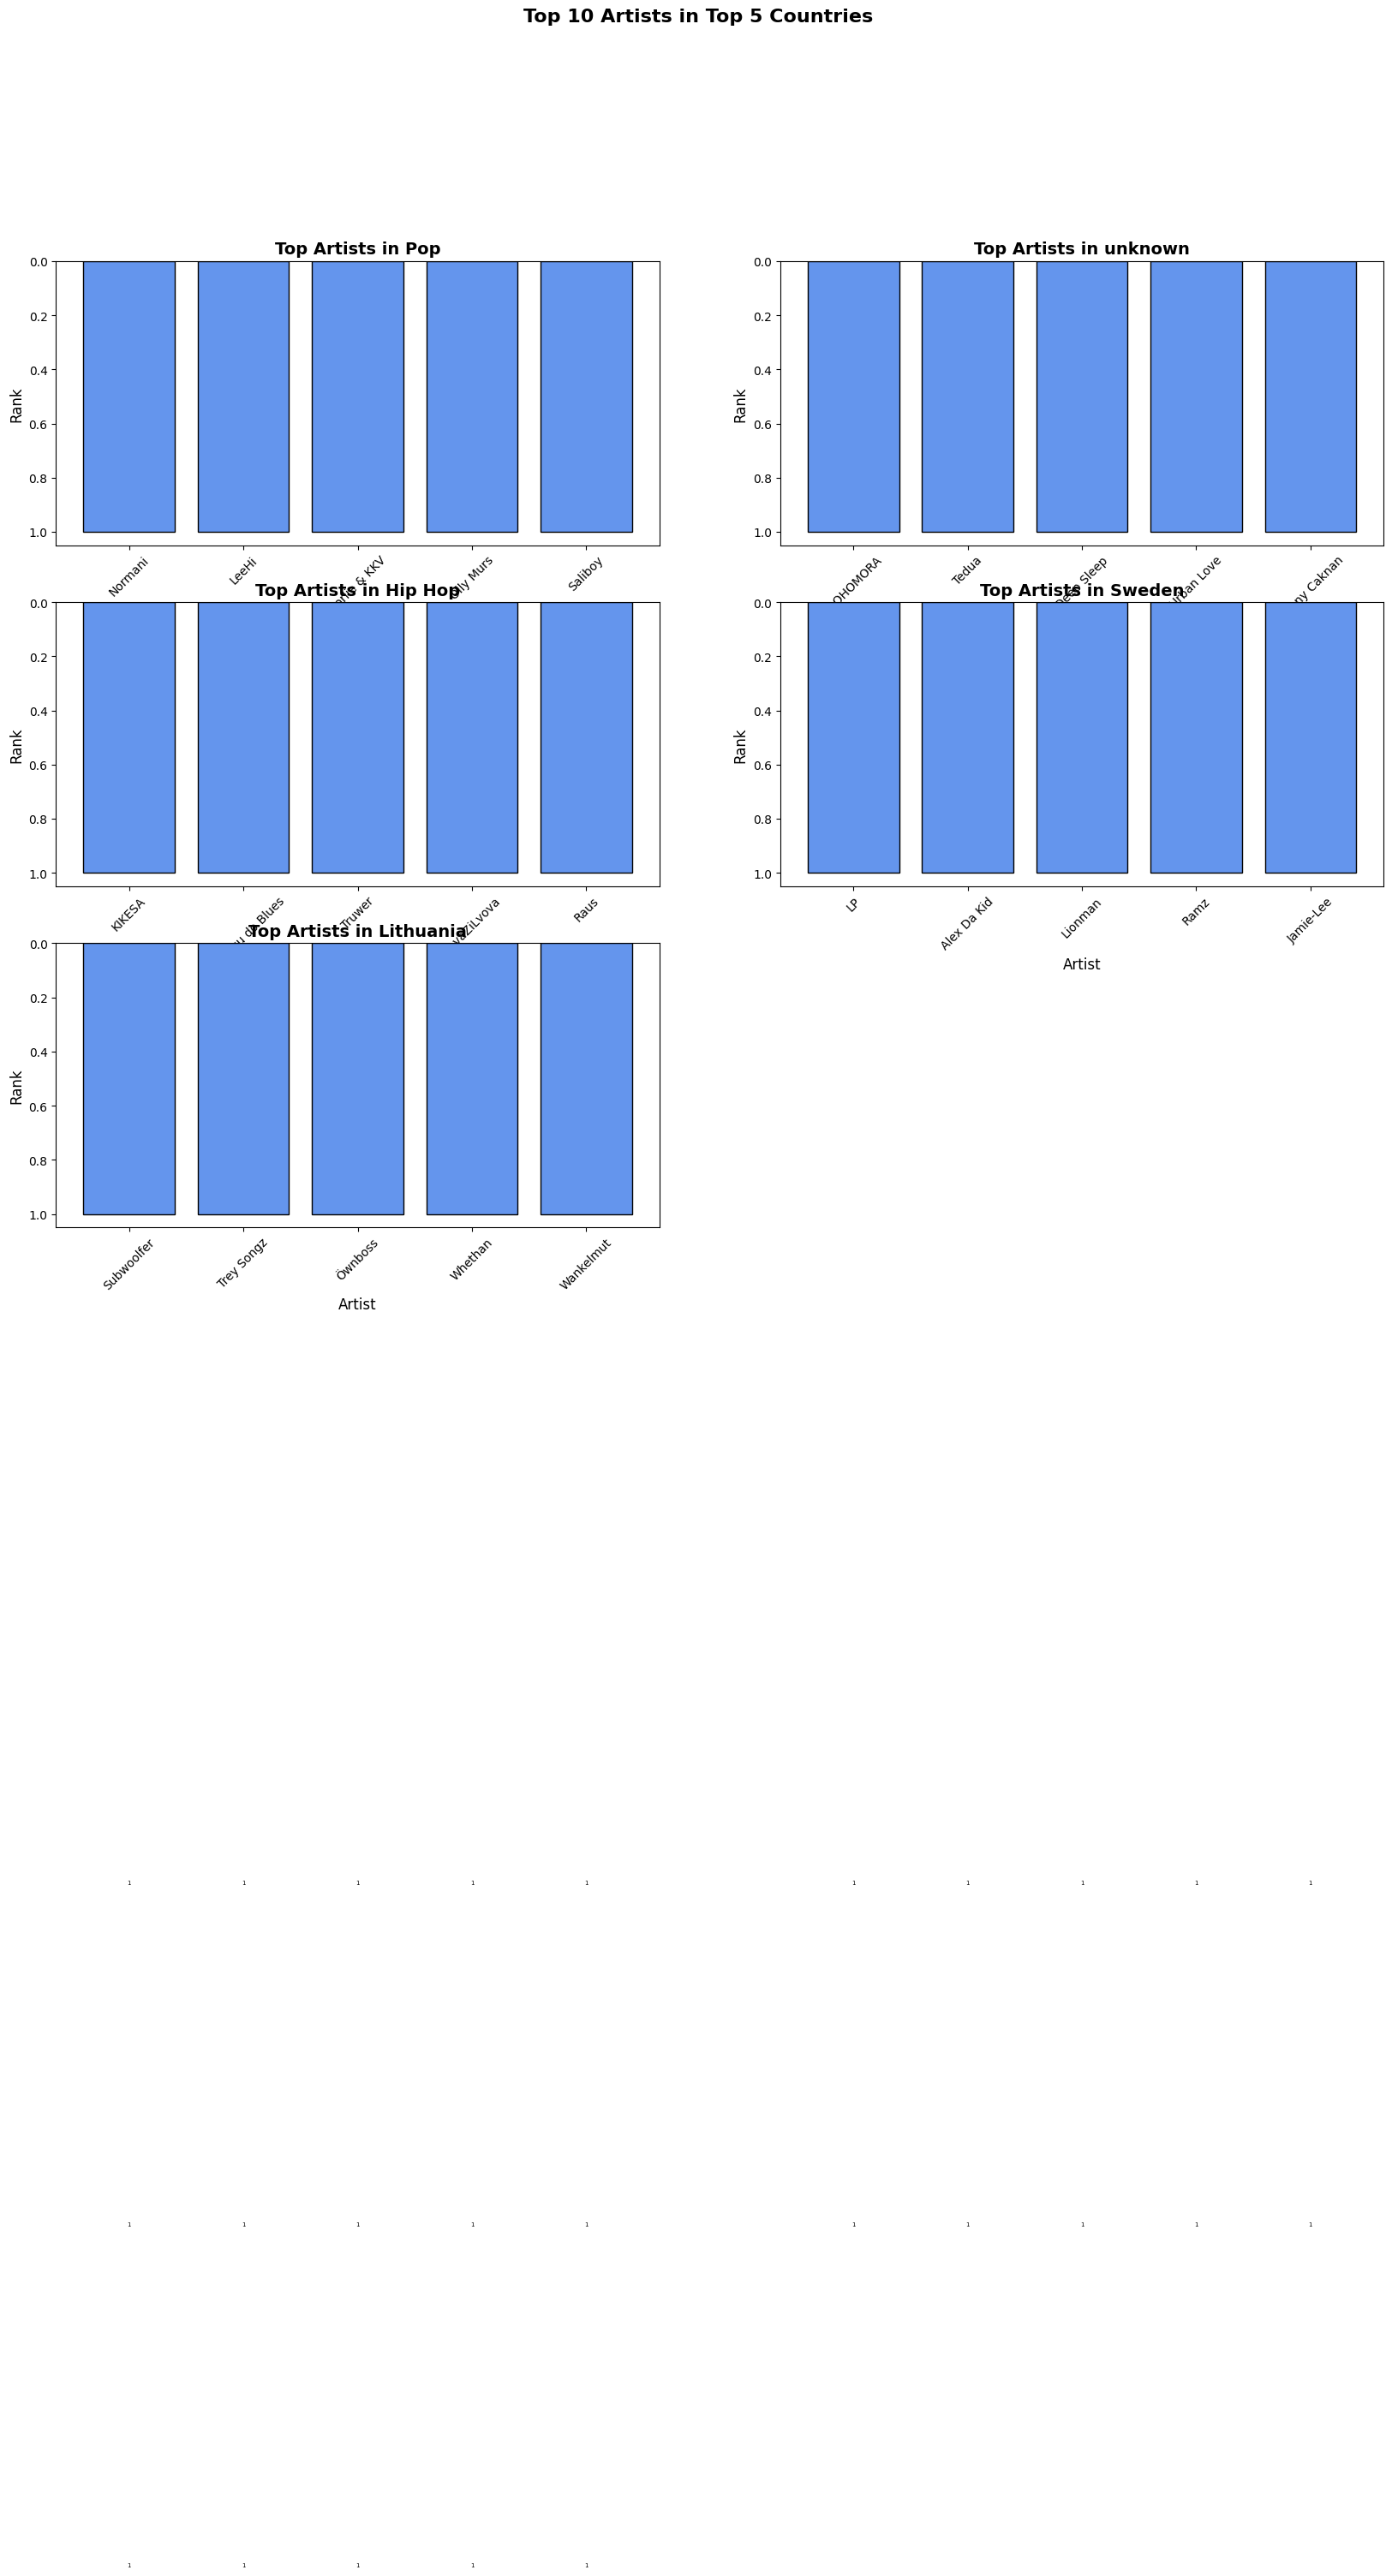

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25), constrained_layout=True)
axes = axes.flatten()

for ax, country in zip(axes, top_5_countries):
    artists = top_artists_final[country]
    
    ax.bar(artists['name'], artists[country], color='cornflowerblue', edgecolor='black')
    ax.set_title(f'Top Artists in {country}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Artist', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelrotation=45)
    
    for i, v in enumerate(artists[country]):
        ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=5, color='black')

# Hide the remaining empty axes
for ax in axes[len(top_5_countries):]:
    ax.set_visible(False)

plt.suptitle('Top 10 Artists in Top 5 Countries', fontsize=16, fontweight='bold')
plt.show()